In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline
import keras
from __future__ import print_function

import cv2
import skimage
from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator          #for loading the images 
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot.tf_keras import PlotLossesCallback
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.4.1


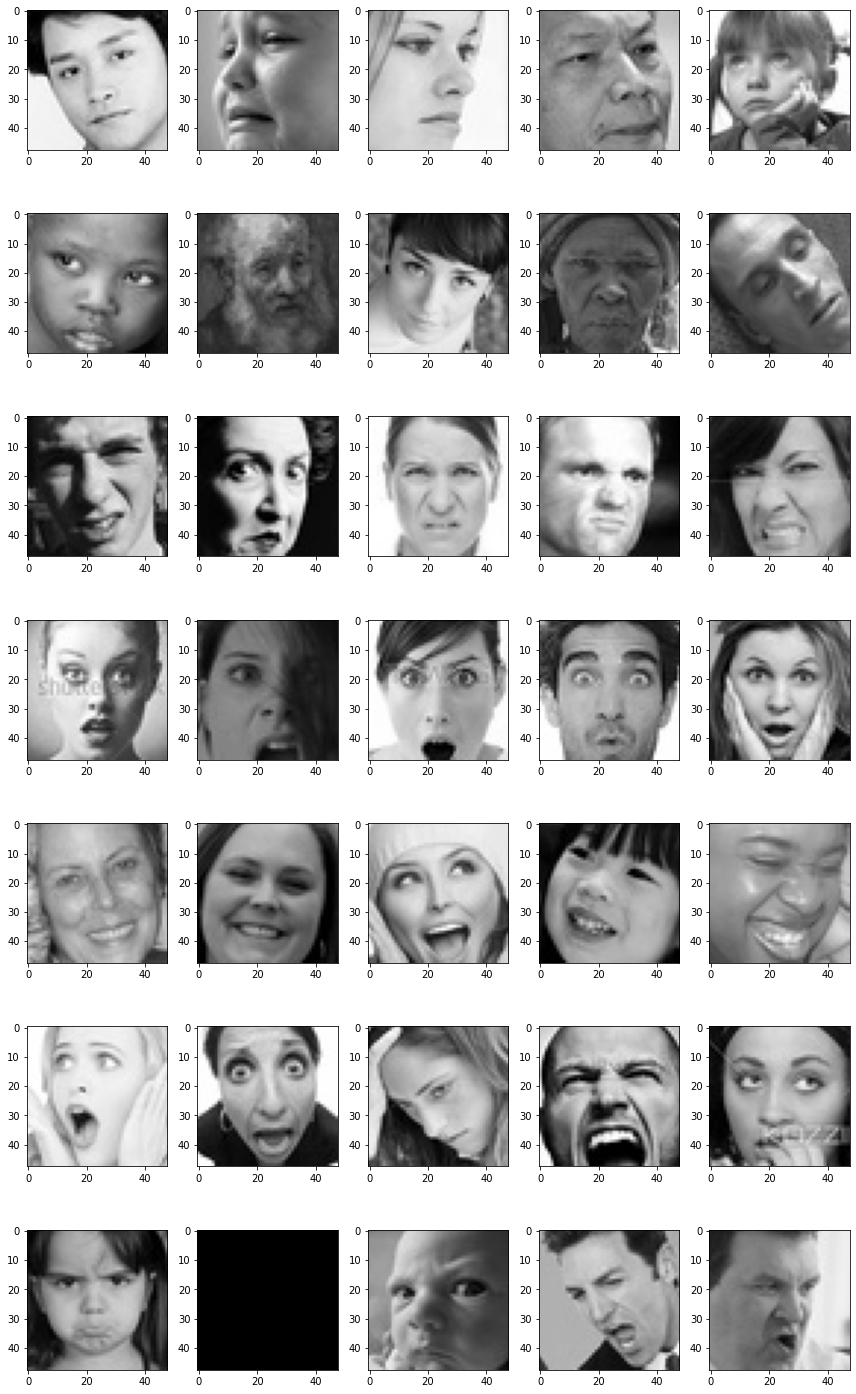

In [13]:
utils.datasets.fer.plot_example_images(plt).show()           #to show some sample images by using the utils function

In [14]:
for expression in os.listdir("test/"):
    print(str(len(os.listdir("test/" + expression))) + " " + expression + " images")    
    #we list the total items in the directories in the train and looking at expression of each 

1247 sad images
1233 neutral images
111 disgust images
831 surprise images
1774 happy images
1024 fear images
958 angry images


In [15]:
for expression in os.listdir("train/"):
    print(str(len(os.listdir("train/" + expression))) + " " + expression + " images")    
    #we list the total items in the directories in the train and looking at expression of each 

4830 sad images
4965 neutral images
436 disgust images
3171 surprise images
7214 happy images
4097 fear images
3995 angry images


In [16]:
img_size = 48           #image size set to 48X48
batch_size = 64         #batch size is set to 64

#DATA GENERATION FOR THE TRAINING SET 
datagen_train = ImageDataGenerator(horizontal_flip=True)       #AUGMENTATION, here we are just flipping the images horizontally
train_generator = datagen_train.flow_from_directory("train/", 
                                                    target_size=(img_size,img_size),    #resize images in case of any anomalies
                                                    color_mode="grayscale",             #since our images are grayscale
                                                    batch_size=batch_size,             
                                                    class_mode='categorical',           #since it is classification problem 
                                                    shuffle=True)                       #to shuffle the data
#DATA GENERATION FOR THE 
datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory("test/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28708 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [19]:
num_classes=7
model = Sequential()



model.add(Conv2D(64, (3,3), padding='same',input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten()),


model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))


model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))


model.add(Dense(7, activation='softmax'))


opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_24 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
activation_24 (Activation)   (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 24, 24, 128)       73856     
_________________________________________________________________
batch_normalization_25 (Batc (None, 24, 24, 128)      

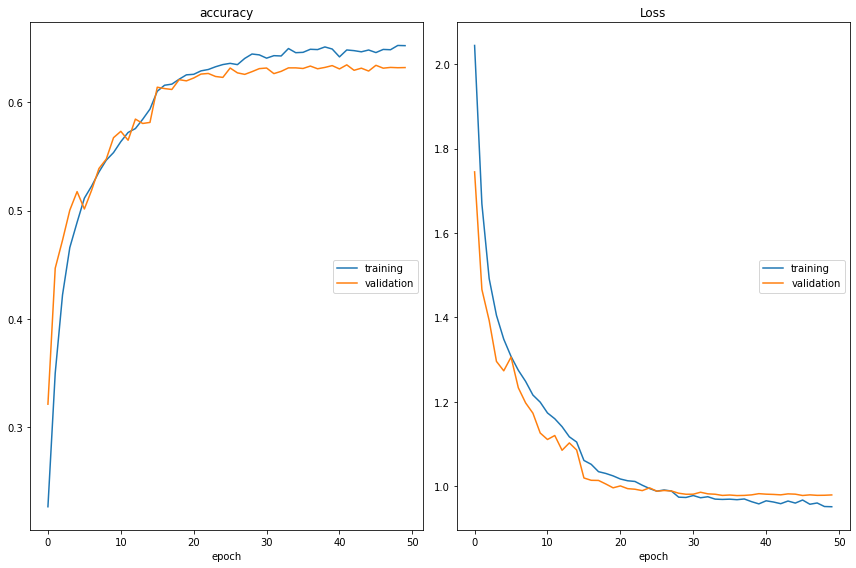

accuracy
	training         	 (min:    0.227, max:    0.653, cur:    0.652)
	validation       	 (min:    0.321, max:    0.635, cur:    0.632)
Loss
	training         	 (min:    0.951, max:    2.044, cur:    0.951)
	validation       	 (min:    0.978, max:    1.745, cur:    0.979)

Epoch 00050: saving model to model_weights2.h5
CPU times: user 1d 2h 40min 37s, sys: 35min 37s, total: 1d 3h 16min 15s
Wall time: 8h 11min 51s


In [20]:
%%time

#NUMBER OF REPETITIONS = 50(considered here)
epochs = 50
#(Number of examples in the training generator)//(batch size i.e. 64(as defined earlier))
steps_per_epoch = train_generator.n//train_generator.batch_size       
validation_steps = validation_generator.n//validation_generator.batch_size


#to reduce the learning rate when we reach near an optimal point
#monitor = 'val_loss'; here we monitor the validation loss
#factor = 0.1; we reduce the learning rate by a favtor of 0.1
#patience = 2; we reduce learning rate when val_loss doesn't change for 2 or more epochs
#min_lr = 0.00001; the minimum learning rate that the model can consider  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')


#checkpoints used in order to save the weights where we are getting the best values 
#we save the weights in the file "model_weights.h5"
#monitor = 'val_accuracy'; this tells us when we want to save the weights, here it is validation accuracy 
#save_weights_only = True; we want to save weights only at this point 
#mode = 'max'; we wnat to save the wieghts with max accuracy
#verbose = 1; we want to print out when we are saving the model
checkpoint = ModelCheckpoint("model_weights2.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)


callbacks = [PlotLossesCallback(), checkpoint, reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

In [23]:
#here we are saving the model weights and architecture in the json file 'model_json'
model_json = model2.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model_json)